## Personality prediction: Introvert or Extrovert (not introvert)

In [110]:
import numpy as np
import plotly.graph_objects as go
import plotly
import pandas as pd
import plotly.offline as py
from scipy.stats import multivariate_normal as g
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
import time
py.init_notebook_mode(connected=True)

def plot_data(classes, count):
    """Bar plots of the data for each class"""
    bar = go.Bar(
        x = classes,
        y = count
    )

    layout = dict(
        title = "Barchart with frequencies",
        xaxis = dict(title = "Classes", type='category'),
        xaxis_tickangle = 45
    )

    fig = go.Figure(data = [bar], layout = layout)
    plotly.offline.iplot(fig)

def plot_traintest(classes, train, test):
    """Train and test barplots"""
    bar1 = go.Bar(
        name = "train",
        x = classes,
        y = train
    )

    bar2 = go.Bar(
        name = "test",
        x = classes,
        y = test
    )

    layout = dict(
        title = "Barchart with frequencies",
        xaxis = dict(title = "Classes", type='category'),
        xaxis_tickangle = 45
    )

    fig = go.Figure(data = [bar1, bar2], layout = layout)
    plotly.offline.iplot(fig)

def print_stats(y_train, X_test, y_test, clf):
    """Print the classification scores and the total report"""
    # claculate elapsed time
    elapsed_time = 0.0
    unit = 'min'
    if (end - start) >= 60.0: elapsed_time = (end - start) / 60.0
    else:
        elapsed_time = (end - start)
        unit = 'sec'
    print('Classification time: {:.2f} {:s}\n\n'.format(elapsed_time, unit))

    # roc curve
    metrics.plot_roc_curve(clf, X_test, y_test)  
    plt.show()   

    # F1 computation
    acc_test_eval = metrics.f1_score(y_train, ypred_eval, average='macro')
    acc_test_test = metrics.f1_score(y_test, ypred, average='weighted') # weighted because the test dataset is imbalanced

    print("Evaluation F1 score: {:.2f}".format(acc_test_eval))
    print(classification_report(y_train, ypred_eval))

    print("Test F1 score: {:.2f}".format(acc_test_test))
    print(classification_report(y_test, ypred))

def clf_kfold(X_train, y_train, classifier):
    """Cross validation and print evaluation scores with ROC curve"""
    # Split training dataset in 10 folds and keep 1/10 for validation and 9/10 for training
    kf = KFold(n_splits=10, shuffle=False, random_state=None)

    f1_scores_train = []
    f1_scores_validation = []
    i = 0
    best_clf = None
    best_acc = 0.0

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    start = time.time()
    for train_indx, test_indx in kf.split(X_train):
        Xvalid_train, Xvalid_test = X_train[train_indx], X_train[test_indx]
        yvalid_train, yvalid_test = y_train[train_indx], y_train[test_indx]

        print('For k = {:d}\n'.format(i+1))

        # fit - predict - evaluate
        clf = classifier

        clf.fit(Xvalid_train, yvalid_train)

        # initialize roc curve
        viz = plot_roc_curve(clf, Xvalid_test, yvalid_test,
                            name='ROC fold {}'.format(i),
                            alpha=0.3, lw=1, ax=ax)
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        ypred_eval = clf.predict(Xvalid_train)
        ypred_valid = clf.predict(Xvalid_test)

        # macro F1 computation
        f1_scores_train.append(metrics.f1_score(yvalid_train, ypred_eval, average='weighted'))
        acc_test = metrics.f1_score(yvalid_test, ypred_valid, average='weighted')
        f1_scores_validation.append(acc_test)

        # keep the clf with the best performance
        if acc_test > best_acc:
            best_acc = acc_test
            best_clf = clf

        print(classification_report(yvalid_train, ypred_eval))
        print(classification_report(yvalid_test, ypred_valid))

        print('\nEvaluation')
        print('----------\n')
        print(confusion_matrix(yvalid_train, ypred_eval))

        print('\nValidation')
        print('----------\n')
        print(confusion_matrix(yvalid_test, ypred_valid))
        print('\n')

        i += 1

    end = time.time()

    # claculate elapsed time
    elapsed_time = 0.0
    unit = 'min'
    if (end - start) >= 60.0: elapsed_time = (end - start) / 60.0
    else:
        elapsed_time = (end - start)
        unit = 'sec'
    print('KFold - classification time: {:.2f} {:s}\n\n'.format(elapsed_time, unit))

    # plot roc curve
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic curve")
    ax.legend(bbox_to_anchor=(1.65, 0), loc="lower right")
    plt.show()

    # F1 scores
    f1_scores_train = np.array(f1_scores_train)
    print('\nKfold train F1')
    print('--------------\n')
    print(f"mean f1: {f1_scores_train.mean():.3f}, sigma f1: {f1_scores_train.std():.3f}, 95% conf: {f1_scores_train.mean()-2*f1_scores_train.std():.3f} - {f1_scores_train.mean()+2*f1_scores_train.std():.3f}")

    f1_scores_validation = np.array(f1_scores_validation)
    print('\nKfold validation F1')
    print('--------------\n')
    print(f"mean f1: {f1_scores_validation.mean():.3f}, sigma f1: {f1_scores_validation.std():.3f}, 95% conf: {f1_scores_validation.mean()-2*f1_scores_validation.std():.3f} - {f1_scores_validation.mean()+2*f1_scores_validation.std():.3f}")

    return best_clf

## Data inspection
Read the csv file containg the dataset

In [86]:
print('Reading csv file...\n')
df = pd.read_csv('../mbti_full_pull.csv') # read data from csv
print(df.info()) # print dataframe info

Reading csv file...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794016 entries, 0 to 1794015
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   author_flair_text  object
 1   body               object
 2   subreddit          object
dtypes: object(3)
memory usage: 41.1+ MB
None


In [87]:
print(df.head()) # take a look at the content

  author_flair_text                                               body  \
0              INTJ  Knowing you're in INTJ is a tool for you to us...   
1              INTJ           You are truly an enlightened mastermind.   
2         INFJ, 26F  You should :) it will help if you have a down ...   
3              INTP  I watch a bit of everything (including hentai)...   
4              INTJ  I don't know if I would count this as a pet pe...   

  subreddit  
0      intj  
1      intj  
2      infj  
3      INTP  
4      intj  


We can see that there are 3 columns, author's description(author_flair_text), the main post texts(body) and the  
subreddit which could be used to extract the labels

## Preprocess data
Inspection of the total data structure along with locating null rows and shrink the dataset size because  
it is too big and the evaluation time of classifiers could be very long.

Check if null values exist

In [88]:
print(df.isnull().sum())

author_flair_text     0
body                 55
subreddit             0
dtype: int64


Drop null values

In [89]:
df = df.dropna()
print('Size after removing nulls: {:d}'.format(len(df)))

Size after removing nulls: 1793961


Clean data by allocating unique and clear classes and text.  
Classes are extracted from subreddit that kind of contains natural language in some cases, so the class value (e.g "ISTJ") should be extracted from plain text and ambiguous classes are removed.

In [90]:
classes = ['ISTJ','ISFJ','INFJ','INTJ','ISTP','ISFP','INFP','INTP','ESTP','ESFP','ENFP','ENTP','ESTJ','ESFJ','ENFJ','ENTJ'] # all the mentioned classes

print("Size before cleaning: {:d}".format(len(df)))

# extract only the cleaned classes that consist of specific and unique value
new_class = []
new_txt = []
print('Cleaning labels...')
for i in range(len(df)):
    lbl = df.iloc[i]['subreddit']
    upperl = lbl.upper()

    if upperl in classes:
        new_class.append(upperl)
        new_txt.append(df.iloc[i]['body'])

mbti = {
    'text': new_txt,
    'class': new_class
}

data = pd.DataFrame(mbti)
del mbti
del df
del new_class
del new_txt
print('Labels cleaned!')
print("Size after cleaning: {:d}".format(len(data)))

Size before cleaning: 1793961
Cleaning labels...
Labels cleaned!
Size after cleaning: 1350826


## Obeserve distribution

In [91]:
freqs = data['class'].value_counts().tolist()
data_classes = data['class'].value_counts().index.tolist()

plot_data(data_classes, freqs)

We can see that there are a lot of classes and their distribution is highly imbalanced.  
According to [this](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/type-tables.htm) table, personality can be classified as introvert and extrovert.  
Also, since we have only two opposing classes (i.e extrovert is-not introvert), the problem can be converted to a binary classification problem.  
So we can simplify the problem by merging all the classes into one binary class (Introvert for example) that takes the value 1 if true and 0 otherwise (Extrovert).

In [92]:
merged_txt = []
merged_class = []

print('Merging labels...')
for i in range(len(data)):
    merged_txt.append(data['text'].iloc[i])
    merged_class.append(data['class'].iloc[i][0])

del data

mbti = {
    'text': merged_txt,
    'class': merged_class
}

data = pd.DataFrame(mbti)
del mbti
del merged_class
del merged_txt

freqs = data['class'].value_counts().tolist()
data_classes = data['class'].value_counts().index.tolist()

plot_data(data_classes, freqs)

Merging labels...


## Shrink dataset proportionally

In [93]:
# find class with minimum length
min_length = np.inf
min_class = ''
for v in data['class'].unique():
    lngth = len(data[data['class'] == v])
    if lngth < min_length:
        min_length = lngth
        min_class = v

ratio = []
for v in data['class'].unique():
    ratio.append(len(data[data['class'] == min_class]) / len(data[data['class'] == v]))

# remove (length-remn) items from min class
remn = 5000
delindex = data[data['class'] == min_class].index[0:(len(data[data['class'] == min_class]) - remn)]
data.drop(delindex, inplace=True)

#remove items from every other class, retaining the length distribution
for v in data['class'].unique():
    if len(data[data['class'] == v]) == remn: continue
    rt = ratio.pop(0)
    new_size = round(float(remn) / rt)

    delindex = data[data['class'] == v].index[0:(len(data[data['class'] == v]) - new_size)]
    data.drop(delindex, inplace=True)

print("Size after removal: {:d}".format(len(data)))

Size after removal: 22774


In [94]:
# plot data
freqs = data['class'].value_counts().tolist()
data_classes = data['class'].value_counts().index.tolist()

plot_data(data_classes, freqs)

## Further text preprocessing
1. make text lower-case
2. remove symbols and punctuation
3. lemmatize verbs

In [95]:
import re
import string
import nltk
from nltk.corpus import wordnet
from textblob import Word

nltk.download("wordnet")

# lower text
data['text'] = data['text'].str.lower()

# convert emoticons to text (not yet implemented)
emots = {
    'happy': [':-)',':)','(-:','(:',':D',':-D'],
    'sad': [':-(',':(',')-:','):'],
    'laugh': ['xD','XD'],
    'funny': [':-P',':P',':p']
}

#remove links
def remove_links(text):
    x = re.sub(r"http\S+", "", text)
    return x

data['text'] = data['text'].apply(lambda text: remove_links(text))

# remove symbols
def remove_punctuation(text):
    symbols = string.punctuation
    return text.translate(str.maketrans('', '', symbols))

data['text'] = data['text'].apply(lambda text: remove_punctuation(text))

# word lemmatizing
def lem(text):
    spl = text.split()
    return " ".join([Word(word).lemmatize("v") for word in spl]) # lemmatize for verbs

data['text'] = data['text'].apply(lambda text: lem(text))

[nltk_data] Downloading package wordnet to /home/matthew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## X, y form
Bring data and class labels to X, y form, where X is the feature array and y is the class array

In [96]:
# create class index dict
def change_values(label):
    if label == 'I': return 1
    else: return 0

data['class'] = data['class'].apply(lambda label: change_values(label))

X = data['text'].to_numpy()
y = data['class'].to_numpy()

## Split dataset into train and test
Since we have imbalanced dataset, stratified split should be chosen

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

# plot train and test frequencies
traindict = {
    'features': X_train,
    'class': y_train.tolist()
}
trainpd = pd.DataFrame(traindict)
testdict = {
    'features': X_test,
    'class': y_test.tolist()
}
testpd = pd.DataFrame(testdict)

freqstrain = trainpd['class'].value_counts().tolist()
freqstest = testpd['class'].value_counts().tolist()
# data_classes = trainpd['class'].value_counts().index.tolist()

plot_traintest(['1','0'], freqstrain, freqstest)
del freqstrain
del freqstest

## Undersampling
The dataset is highly imbalanced and the smallest class has a few data compared to the majority class.  
Since there is a satisfying amount of training data, undersampling of the major 'I' class can be performed.

In [98]:
# find class with minimum length
min_length = np.inf
for v in trainpd['class'].unique():
    lngth = len(trainpd[trainpd['class'] == v])
    if lngth < min_length:
        min_length = lngth

delindex = trainpd[trainpd['class'] == 1].index[0:(len(trainpd[trainpd['class'] == 1]) - min_length)]
trainpd.drop(delindex, inplace=True)

freqstrain = trainpd['class'].value_counts().tolist()
freqstest = testpd['class'].value_counts().tolist()

plot_traintest(['1','0'], freqstrain, freqstest)

## Feature extraction
Inspect text and find possible features and relations with Tf-idf  
The vectorizer parameters are tuned in order to find words with max information

In [99]:
from sklearn.feature_extraction import text as fet
from nltk.corpus import stopwords
# find frequency of each word in each text fragment of each row (tfidf: term frequency * inverse document frequency)

nltk.download("stopwords")

# stopword_list = ['the','a','an','be','am','are','for','of','or','that','this','which','is','then','than','www','youtube','com','reddit','wiki','wikipedia','org']

vectorizer = fet.TfidfVectorizer(max_features=10000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'), ngram_range=(1,3), use_idf=True)
# vectorizer.fit(X_train)
# X_train = vectorizer.transform(X_train).toarray()
# X_test = vectorizer.transform(X_test).toarray()

# features = vectorizer.get_feature_names()   # features are every counted word in the entire corpus and their values are tfidf's
# print('TfidfVectorizer')
# print('----------------')
# print('Feature vector length: {:d}'.format(len(features)))
# print('Feature vector shape (train): {:}'.format(X_train.shape))
# print('Feature vector shape (test): {:}'.format(X_test.shape))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matthew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
# Alternative method, using gensim models for word embeddings, such as Word2Vec, FastText etc.
# from gensim.models import FastText

In [101]:
# from gensim.models import FastText
# import multiprocessing

# cores = multiprocessing.cpu_count()

# # create a list of words of the corpus
# words = [row.split() for row in data['text']]

# model = FastText(size=4, window=2, min_count=1, workers=cores-1)
# model.build_vocab(sentences=words)
# model.train(sentences=words, total_examples=len(words), epochs=20)

## Oversampling
The dataset is highly imbalanced and the smallest class has too few data compared to the majority class.  
Smote can be used for that case, in order to oversample the training dataset and to balance all classes

In [102]:
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)

# # plot train frequencies
# traindict = {
#     'features': X_train,
#     'class': y_train.tolist()
# }
# trainpd = pd.DataFrame(traindict)

# freqstrain = trainpd['class'].value_counts().tolist()
# data_classes = trainpd['class'].value_counts().index.tolist()

# plot_data(data_classes, freqstrain)

Use PCA to reduce feature vector dimensions

In [103]:
# from sklearn.decomposition import PCA
# # from sklearn.preprocessing import StandardScaler

# # scaler = StandardScaler()
# # scaler.fit(X_train.toarray())
# # X_train = scaler.transform(X_train.toarray())
# # X_test = scaler.transform(X_test.toarray())

# pca = PCA(n_components=4) # convert feature vector space into 4 dimensions
# # pca = PCA(0.95) # find the minimum principal components in order to retain 95% of initial variance
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)
# print(X_train.shape)
# print(X_test.shape)

# Models
Train different binary classifiers starting from the fastest (e.g Naive Bayes, Decision Tree).  
I also used classifiers such as gradient boosting and neural networks which support high feature dimensionality.  
Trying to "wrapper-ify" the method of feature suitability by evaluating those different classifiers' performance  
  
The evaluation score for each classifier is going to be weighted F1 because we have imbalanced test data both in cross validation and in the final test data,  
as well as the plot of ROC/AUC curve in order to visualize the process and to compare the performance of the classifiers.

### Naive Bayes

For k = 1

              precision    recall  f1-score   support

           0       0.93      0.01      0.01      3608
           1       0.78      1.00      0.88     12789

    accuracy                           0.78     16397
   macro avg       0.85      0.50      0.45     16397
weighted avg       0.81      0.78      0.69     16397

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       392
           1       0.78      1.00      0.88      1430

    accuracy                           0.78      1822
   macro avg       0.39      0.50      0.44      1822
weighted avg       0.62      0.78      0.69      1822


Evaluation
----------

[[   26  3582]
 [    2 12787]]

Validation
----------

[[   0  392]
 [   0 1430]]


For k = 2

              precision    recall  f1-score   support

           0       0.85      0.01      0.01      3608
           1       0.78      1.00      0.88     12789

    accuracy                           0.78     1639

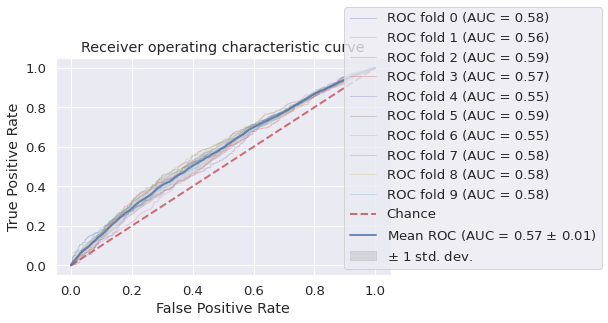


Kfold train F1
--------------

mean f1: 0.687, sigma f1: 0.002, 95% conf: 0.684 - 0.691

Kfold validation F1
--------------

mean f1: 0.684, sigma f1: 0.016, 95% conf: 0.652 - 0.717


In [111]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

clf = make_pipeline(vectorizer, MultinomialNB())
best_clf = clf_kfold(X_train, y_train, clf)

### Garadient boosting

KFold - classification time: 4.62 min




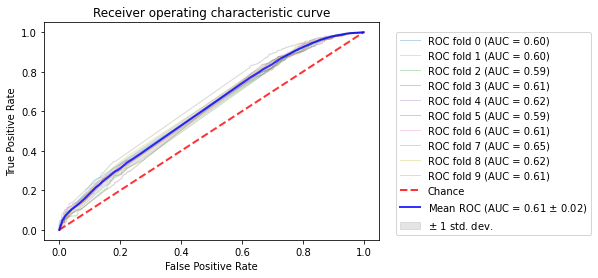

Kfold train F1
--------------

mean f1: 0.511, sigma f1: 0.002, 95% conf: 0.507 - 0.515

Kfold validation F1
--------------

mean f1: 0.494, sigma f1: 0.012, 95% conf: 0.470 - 0.518


In [89]:
from sklearn.ensemble import GradientBoostingClassifier

clf = make_pipeline(vectorizer, GradientBoostingClassifier(max_depth=3))
best_clf = clf_kfold(X_train, y_train, clf)

### SVM

In [94]:
from sklearn.svm import SVC

clf = make_pipeline(vectorizer, SVC(C=1, kernel='linear', gamma='auto'))
best_clf = clf_kfold(X_train, y_train, clf)

### Decision tree

KFold - classification time: 1.63 min




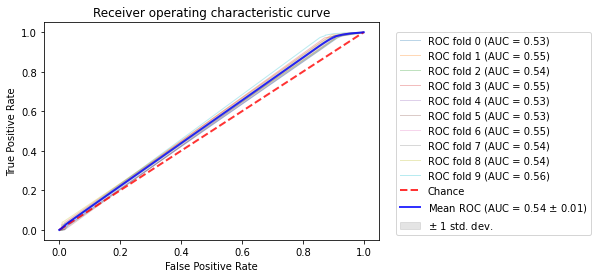

Kfold train F1
--------------

mean f1: 0.536, sigma f1: 0.007, 95% conf: 0.523 - 0.549

Kfold validation F1
--------------

mean f1: 0.517, sigma f1: 0.016, 95% conf: 0.485 - 0.549


In [27]:
from sklearn import tree

clf = make_pipeline(vectorizer, tree.DecisionTreeClassifier(max_depth=6))
best_clf = clf_kfold(X_train, y_train, clf)

### Xgboost

[02:28:40] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:42] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:45] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:47] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:49] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:51] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:53] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:57] WARNING: ../src/objective/regression_

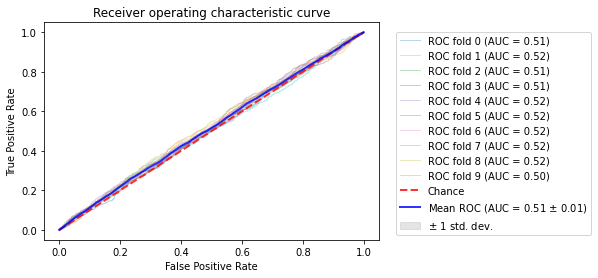

Kfold train F1
--------------

mean f1: 0.562, sigma f1: 0.004, 95% conf: 0.555 - 0.570

Kfold validation F1
--------------

mean f1: 0.453, sigma f1: 0.007, 95% conf: 0.439 - 0.468


In [58]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

clf = XGBClassifier(objective ='reg:linear')
best_clf = clf_kfold(X_train, y_train, clf)

### Random forest 

Classification time: 11.42 sec




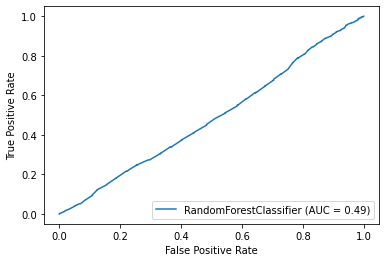

Evaluation F1 score: 0.98
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6300
           1       0.99      1.00      0.99     22395

    accuracy                           0.99     28695
   macro avg       0.99      0.98      0.98     28695
weighted avg       0.99      0.99      0.99     28695

Test F1 score: 0.69
              precision    recall  f1-score   support

           0       0.23      0.02      0.04       700
           1       0.78      0.98      0.87      2489

    accuracy                           0.77      3189
   macro avg       0.51      0.50      0.45      3189
weighted avg       0.66      0.77      0.69      3189



In [45]:
from sklearn.ensemble import RandomForestClassifier

best_clf = RandomForestClassifier(n_estimators=100, random_state=None) # ideal for non-linear data
start = time.time()
best_clf.fit(X_train, y_train)
ypred_eval = best_clf.predict(X_train)
end = time.time()
ypred = best_clf.predict(X_test)

print_stats(y_train, X_test, y_test, best_clf)

## Production test
Predict the class for the test dataset using the classifier with the best validation accurracy

F1 score: 0.69
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      1000
           1       0.78      1.00      0.88      3555

    accuracy                           0.78      4555
   macro avg       0.89      0.50      0.44      4555
weighted avg       0.83      0.78      0.69      4555



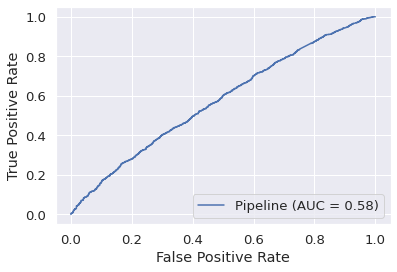

In [112]:
y_pred = best_clf.predict(X_test)

f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
print('F1 score: {:.2f}'.format(f1_score))
print(classification_report(y_test, y_pred))

metrics.plot_roc_curve(best_clf, X_test, y_test)  
plt.show()

## Conclusion
We can see that the overall scores are around weighted 70%, but we cannot deem these models accurrate, because in every cross validation and prediction with the train data,  
the same score is yielded. In cases where train data are given for prediction, we should expect a score close to 1.  
That probably means we have underfitting of the training data, due to the feature selection and the sparse tf-idf matrix.